**In this notebook:** 
    
    - we build a deterministic SIR model 
    - we solve the system of ODEs with odeint
    - we simulate epidemic spreading in absence of intervientions and compute the final attack rate
    - we test two scenarios of susceptibility for children: 10%% and 50% relative susceptibility with respect to adults

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import cm
import math
import random

import geopandas as gp 
from shapely.geometry import Point, LineString

import datetime as dt

import time

import scipy.stats as st

import seaborn as sns

from scipy.integrate import odeint
from numpy import linalg as LA

from itertools import chain

# read population data

In [2]:
# # read population data

data_pop_grouped = pd.read_csv("./../data/pop_size_by_age_SEP_edu.csv")

dict_pop_full = dict(zip(data_pop_grouped[['age_group',
                           'sep_level', 'edu_level']].apply(lambda x:
                                               x[0]+", "+x[1]+", "+x[2], axis=1).values,
                   data_pop_grouped['population']))
                   
pop_age = data_pop_grouped.groupby('age_group')['population'].sum()
pop_age = dict(zip(pop_age.index, pop_age.values))

distrib_pop = data_pop_grouped.groupby('age_group')['population'].sum()/data_pop_grouped['population'].sum()
distrib_pop = dict(zip(distrib_pop.index, distrib_pop.values))

# intermediate contact matrix

In [3]:
intermediate_matrix_rec = pd.read_csv("./../output/matrices/intermediate_matrix_rec.csv", index_col = 0)
intermediate_matrix_rec = intermediate_matrix_rec.fillna(0)

# functions to generate expanded contact matrix

In [4]:
def diag_block_children(age, q1_sep):

    #age = '0-14'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 0., 1., 0.,  
                   0., 0., 0., 0.,  
                   -1., 0., 0., 0.,  
                   0., 0., 0., 0.], ## reciprocity
                  #[1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  ###[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  ###[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,  
                   1., 1., 0., 0.,  
                   0., 0., 0., 0.,  
                   0., 0., 0., 0.], ## assortativity sep dimension
                   #### null values
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11], 
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  0., #0., 0., 0., 0., 0., 
                  #q111*intermediate_matrix_rec.iloc[0:4][age].iloc[0],
                  #q112*intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  #q121*intermediate_matrix_rec.iloc[0:4][age].iloc[2],
                  #q122*intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  q1_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  #q1_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.iloc[0:4][age].iloc[0]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.iloc[0:4][age].iloc[2])
                  ### null values
                  0., 0., 
                  0., 0., 0., 0., 
                  0., 0.,
                  0., 0., 0., 0.])

    x = np.linalg.solve(a, b)
    
    return x

In [5]:
def diag_block_age(age, q11, q12, q21, q22, q_sep, q_edu):

    #age = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 1., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 1., 0.,
                   0., -1., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., -1., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., -1., 0.], ## reciprocity
                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.], ## assortativity edu dimension


                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  0., 0., 0., 0., 0., 0.,
                  q11*intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  q12*intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  q21*intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  q22*intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  q_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  q_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.loc[age+tag_21][age])])

    x = np.linalg.solve(a, b)
    
    return x

In [6]:
def offdiag_block_children(age_i, age_j, q11, q21, q12_sep):

    #age_i = '0-14'
    #age_j = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                  #[0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                #[0., 0., 0., 0.,  dict_pop_full[age_i+tag_12], 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., -dict_pop_full[age_j+tag_11], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_12], 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_21], 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_22], 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0., 1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1.,  0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_21],  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -dict_pop_full[age_j+tag_22], 0.], ## reciprocity

                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  dict_pop_full[age_i+tag_22], 0., 0., 0.,
                #   0., 0., 0., -dict_pop_full[age_j+tag_11],  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_22], 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_22], 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_21],  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                 # [dict_pop_full[age_i+tag_11], 0., dict_pop_full[age_i+tag_11], 0.,
                 #  0., 0., 0., 0.,
                 #  dict_pop_full[age_i+tag_21], 0., dict_pop_full[age_i+tag_21], 0.,
                 #  0., 0., 0., 0.,
                 #  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                 ### null values
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
               ],
                )

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #q12*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #q22*intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  #r1*(1.-q11)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0],
                  #r2*(1.-q12)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  #r3*(1.-q21)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2],
                  0., 0., 0., 0.,
                  #0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  #0., 0., 0., #0.,
                  q12_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  #q12_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2]),
                  ### null values (16)
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                 ])

    x = np.linalg.solve(a, b)
    
    return x

In [7]:
def offdiag_block_age(age_i, age_j, q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu):

    #age_i = '15-24'
    #age_j = '25-64'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                 [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.], ## reciprocity

                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                  ])

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  q12*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  q22*intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  r1*(1.-q11)*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  r2*(1.-q12)*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  r3*(1.-q21)*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  q_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  q_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.loc[age_i+tag_21][age_j]),
                 ])

    x = np.linalg.solve(a, b)
    
    return x

In [8]:
matrix_features = pd.read_csv("./../output/matrices/10000_matrices_characteristics.csv")
params = pd.read_csv("./../output/matrices/10000_sampled_combinations.csv")

In [9]:
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'q_sep', 'q_edu']):
    params['block1_{}'.format(q)] = params['block1'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block2_{}'.format(q)] = params['block2'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block3_{}'.format(q)] = params['block3'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'r1', 'r2', 'r3', 'q_sep', 'q_edu']):
    params['block12_{}'.format(q)] = params['block12'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block13_{}'.format(q)] = params['block13'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block23_{}'.format(q)] = params['block23'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q_sep']):
    params['block0_{}'.format(q)] = params['block0'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    
for h,q in enumerate(['q11', 'q21', 'q_sep']):
    params['block01_{}'.format(q)] = params['block01'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    params['block02_{}'.format(q)] = params['block02'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

    params['block03_{}'.format(q)] = params['block03'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

In [10]:
def generate_matrix(combination):
    
    c = combination

    ## diagonal block 1
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block1_' in col]].values
    x1 = diag_block_age('15-24', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 2
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block2_' in col]].values
    x2 = diag_block_age('25-64', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 3
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block3_' in col]].values
    x3 = diag_block_age('65+', q11, q12, q21, q22, q_sep, q_edu)

    ## block 12
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block12_' in col]].values
    x12 = offdiag_block_age('15-24', '25-64', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 13
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block13_' in col]].values
    x13 = offdiag_block_age('15-24', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 23
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block23_' in col]].values
    x23 = offdiag_block_age('25-64', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)
    
    ## diagonal block 0
    par = params.iloc[c][[col for col in params.columns if 'block0_' in col]].values
    q_sep = par[0]
    x0 = diag_block_children('0-14', q_sep)        

    ## block 01
    par = params.iloc[c][[col for col in params.columns if 'block01_' in col]].values
    q11, q21, q_sep = par
    x01 = offdiag_block_children('0-14', '15-24', q11, q21, q_sep)

    ## block 02
    par = params.iloc[c][[col for col in params.columns if 'block02_' in col]].values
    q11, q21, q_sep = par
    x02 = offdiag_block_children('0-14', '25-64',q11, q21, q_sep)

    ## block 0
    par = params.iloc[c][[col for col in params.columns if 'block03_' in col]].values
    q11, q21, q_sep = par
    x03 = offdiag_block_children('0-14', '65+',q11, q21, q_sep)

    matrix_expanded_positive = np.zeros((16,16))

    matrix_expanded_positive[0:4,0:4] = x0.reshape(4,4)
    matrix_expanded_positive[4:8,4:8] = x1.reshape(4,4)
    matrix_expanded_positive[8:12,8:12] = x2.reshape(4,4)
    matrix_expanded_positive[12:16,12:16] = x3.reshape(4,4)

    matrix_expanded_positive[0:4,4:8] = x01.reshape(8,4)[:4]
    matrix_expanded_positive[4:8,0:4] = x01.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,8:12] = x02.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,0:4] = x02.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,12:16] = x03.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,0:4] = x03.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,8:12] = x12.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,4:8] = x12.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,12:16] = x13.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,4:8] = x13.reshape(8,4)[4:]

    matrix_expanded_positive[8:12,12:16] = x23.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,8:12] = x23.reshape(8,4)[4:]

    matrix_expanded_positive = pd.DataFrame(matrix_expanded_positive)
    matrix_expanded_positive.index = intermediate_matrix_rec.index
    matrix_expanded_positive.columns = intermediate_matrix_rec.index

    matrix_expanded = matrix_expanded_positive.copy()
    
    df = matrix_expanded.values  # Convert DataFrame to NumPy array
    
    if np.allclose(df, df.T, atol=1e-8)==False: ## check symmetry of the matrix
        sys.exit()
        
    else:    
        ## this is the symmetric matrix with the total number of contacts between two groups 
        ## T_ij = M_ij*N_i = M_ji*N_j = T_ji 

        ## to compute the contact matrix of the number of contacts per participant, dived each row by the size of the 
        ## M_ij = T_ij/N_i
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]!= 0.:
                matrix_expanded.loc[g] = matrix_expanded.loc[g]/dict_pop_full[g]
            else:
                matrix_expanded.loc[g] = np.nan
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]== 0.:
                matrix_expanded[g] = np.nan
                
        matrix_expanded = matrix_expanded.dropna(how='all', axis = 0)
        matrix_expanded = matrix_expanded.dropna(how='all', axis = 1)
    
        return matrix_expanded

# functions to compute next generation matrix

In [17]:
def aggregate_matrix(M):
    avg = 0
    for i in M.index:
        avg += sum(M.loc[i])*dict_pop_full[i]/sum([dict_pop_full[j] for j in dict_pop_full.keys()])
    return avg

def compute_next_gen_matrix_SIR(M):
    
    ### SIR
    F = np.zeros((14, 14))
    for i,i_tag in enumerate(M.index):
        for j,j_tag in enumerate(M.columns):
            F[i,j]=dict_susc[i_tag]*dict_pop_full[i_tag]*M.loc[i_tag,j_tag]/dict_pop_full[j_tag]
    V = np.zeros((14, 14))
    for i in range(14):
        V[i,i] = gamma

    Vinv= np.linalg.inv(V)
    K_sir = np.dot(F,Vinv)
    
    return K_sir

def compute_beta(M):
    
    K_sir = compute_next_gen_matrix_SIR(M)
    
    beta_1 = np.around(R0/LA.eigvals(K_sir).max(),7)
    
    M = np.matrix(M)
    
    #beta_2 = np.around(R0*gamma/LA.eigvals(M).max(),7)
    
    return beta_1

# epidemiological parameters

In [29]:
susc_children = 1.

dict_susc = {}

for i_tag in dict_pop_full.keys():
    if '0-14' in i_tag:
        dict_susc[i_tag] = susc_children
    else:
        dict_susc[i_tag] = 1.

In [30]:
# global parameters

N = sum(dict_pop_full[k] for k in dict_pop_full.keys())

#latent = 3.7       # latency period (non infectious) (days)
infection = 3.   # infectious period (days)

# compute transition rates
# sigma=1./latent
gamma=1./infection    # inverse of infectious period duration

R0 = 1.5

## test

In [31]:
M = generate_matrix(2545)
M.head()

tag_index,"0-14, low SEP, low edu","0-14, high SEP, low edu","15-24, low SEP, low edu","15-24, low SEP, high edu","15-24, high SEP, low edu","15-24, high SEP, high edu","25-64, low SEP, low edu","25-64, low SEP, high edu","25-64, high SEP, low edu","25-64, high SEP, high edu","65+, low SEP, low edu","65+, low SEP, high edu","65+, high SEP, low edu","65+, high SEP, high edu"
tag_index,,,,,,,,,,,,,,
"0-14, low SEP, low edu",3.737806,1.827321,0.063427,0.059361,0.395179,0.000346,1.059815,0.285092,1.592600,0.445709,0.041368,0.024896,0.260635,0.158190
"0-14, high SEP, low edu",0.829532,4.703264,0.239770,0.009179,0.250716,0.012951,0.447753,0.448745,0.857677,1.629941,0.109621,0.026423,0.042726,0.245425
"15-24, low SEP, low edu",0.098992,0.824330,1.190043,0.112406,1.930005,0.229741,0.222841,0.115950,1.868903,1.698570,0.140392,0.027435,0.510781,0.289159
"15-24, low SEP, high edu",0.988122,0.336572,1.198869,0.535993,2.554285,0.043025,3.368829,0.063205,2.653518,0.807636,0.398665,1.178991,0.633884,0.734703
"15-24, high SEP, low edu",0.295475,0.412943,0.924615,0.114733,1.669425,0.075911,0.656853,0.515815,1.154166,1.059294,0.075550,0.057237,0.349188,0.221661


In [32]:
compute_beta(M)

0.0673434

In [33]:
LA.eigvals(compute_next_gen_matrix_SIR(M)).max()*gamma, LA.eigvals(np.matrix(M)).max()

(7.424631667601251, 7.4246316676012505)

In [34]:
aggregate_matrix(generate_matrix(2545)), aggregate_matrix(generate_matrix(8545))

(6.638390907928805, 6.638390907928805)

# epidemic spreading and attack rate

In [35]:
# SIR

# number of (disease) compartments
num_comp = 3

def sir(current_cond, t, bet, cont_red_matrix):
 
    Q = {}
        
    i=0
    for group in M.index: 
        Q['s_'+group],Q['i_'+group],Q['r_'+group] = current_cond[i:i+num_comp]
        i=i+num_comp
                
    lambd = {}
    for g in M.index:
        l = 0 
        for g2 in M.columns:
            M_control = np.multiply(M, cont_red_matrix)
            l += dict_susc[g]*bet*M_control.loc[g,g2]*Q['i_'+g2]/dict_pop_full[g2]
        lambd[g] = l
    
    d_Eqs = {}
        
    for group in M.index:         
        d_Eqs[group + "_S"] = - lambd[group]*Q['s_'+group]
        d_Eqs[group + "_I"] = lambd[group]*Q['s_'+group] - gamma*Q['i_'+group]    
        d_Eqs[group + "_R"] = gamma*Q['i_'+group]
        
    Eqs = list(d_Eqs.values())
    return Eqs

In [36]:
save_output = pd.DataFrame()

for comb in range(0,100):
    
    # generate contact matrix
    M = generate_matrix(comb)
    # compute bera
    beta = compute_beta(M)
    
    # start and end of the simulation
    t_start = 1
    t_end = 200
    t_step = 1
    t_interval = np.arange(t_start, t_end, t_step)

    # intitial conditions
    seed = 10
    init_cond = [[dict_pop_full[g], 0, 0] 
                              if g != '25-64, low SEP, high edu' 
                              else [dict_pop_full[g]-seed, seed, 0]
                              for g in M.index]
    
    init_cond = list(chain.from_iterable(init_cond)) 

    
    # control strategy: reduction of contacts
    cont_red_matrix = np.ones((14,14))
    #cont_red = 0.
    #for hh in np.array([1,3,5,7,9,11]):
    #    cont_red_matrix[:,hh] = 1.-cont_red

    # solve system of ODEs
    Ret = odeint(sir, init_cond, t_interval, args = (beta,cont_red_matrix,))
    
    # extract trajectory over time of S, I, R for each subgroup
    i=0
    Q={}
    for group in M.index: 
        Q['s_'+group],Q['i_'+group],Q['r_'+group] = Ret.T[i:i+num_comp]
        i=i+num_comp
     
    # compute total S, I, R over time, summing over subgroup
    res = {}
    for compart in ['s', 'i', 'r']:
        res[compart] =np.zeros(len(t_interval))
        for group in M.index:
            res[compart]+=Q[compart+'_'+group]
            
    if comb%10 ==0:
        print(comb)
    
    # prepare output to be saves
    output = {}
    output['comb'] = comb
    # save epidemic tail to check if epidemic is over
    output['epi_tail'] = res['i'][-1]
    
    # compute attack rate
    
    for h,group in enumerate(M.index):
        # attack rate by socio-demographic group
        output['AR_'+group] = 100*Q['r_'+group][-1]/dict_pop_full[group]
    
    # attack rate overall
    output['AR_overall'] = 100*res['r'][-1]/N
    
    #attack rate by age groups
    for age in ['0-14', '15-24', '25-64', '65+']:
        output['AR_'+age] = 0

        for h,level in enumerate(['low SEP, low edu',
                                  'low SEP, high edu',
                                  'high SEP, low edu',
                                  'high SEP, high edu']):
            group = age+", "+level
            if 'r_'+group in Q.keys():
                output['AR_'+age] = output['AR_'+age]+100*Q['r_'+group][-1]/pop_age[age]
    
    save_output = pd.concat((save_output, pd.DataFrame(output, index=[comb])))

0
10
20
30


KeyboardInterrupt: 

In [37]:
save_output.head()

,comb,epi_tail,"AR_0-14, low SEP, low edu","AR_0-14, high SEP, low edu","AR_15-24, low SEP, low edu","AR_15-24, low SEP, high edu","AR_15-24, high SEP, low edu","AR_15-24, high SEP, high edu","AR_25-64, low SEP, low edu","AR_25-64, low SEP, high edu",...,"AR_25-64, high SEP, high edu","AR_65+, low SEP, low edu","AR_65+, low SEP, high edu","AR_65+, high SEP, low edu","AR_65+, high SEP, high edu",AR_overall,AR_0-14,AR_15-24,AR_25-64,AR_65+
0,0,1.171040,69.451855,69.349803,61.606648,79.347945,54.537347,52.550894,44.090189,48.922454,...,45.996650,34.020251,37.885597,30.219588,43.688630,48.246963,69.381666,57.204585,45.639574,34.475273
1,1,1.146055,69.375469,69.330448,62.993554,78.181286,53.592006,54.252920,44.699282,49.752083,...,46.013329,33.526645,38.733739,30.148257,43.947381,48.189628,69.344505,57.097188,45.583207,34.425839
2,2,1.153927,69.844099,69.096355,62.076067,79.975685,53.842425,55.280935,45.169140,49.195890,...,45.495440,32.337189,38.313691,30.360867,44.872980,48.179436,69.329818,57.089682,45.582866,34.389188
3,3,1.120090,69.776843,69.125495,62.005613,79.832494,54.165703,52.439205,44.521290,50.153323,...,45.675308,32.182461,38.232235,30.764346,44.280270,48.178198,69.328861,57.099984,45.570762,34.413114
4,4,1.189351,69.662791,69.126273,62.841829,79.929872,53.636021,52.091489,44.309051,48.794931,...,45.943316,32.565907,38.912621,30.338506,44.286927,48.132532,69.293786,57.002751,45.536068,34.354662


In [38]:
save_output.to_csv("./../output/epidemic_output/output_simulations_susc_children{}.csv".format(susc_children), 
                   index=False)

## check epidemic dynamics

In [39]:
comb

35

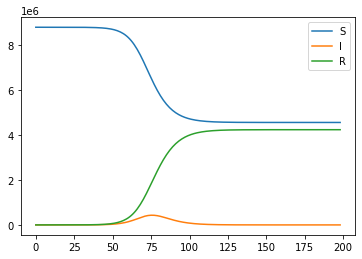

In [41]:
plt.plot(res['s'], label = 'S')
plt.plot(res['i'], label = 'I')
plt.plot(res['r'], label = 'R')

plt.legend()

plt.show()

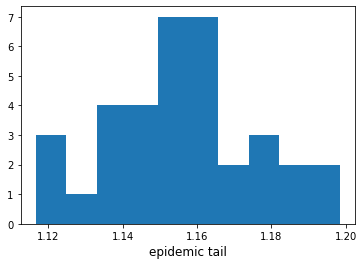

In [46]:
plt.hist(save_output['epi_tail'])
plt.xlabel("epidemic tail", fontsize=12)
plt.show()

## check growth rate

0.1661094351911156


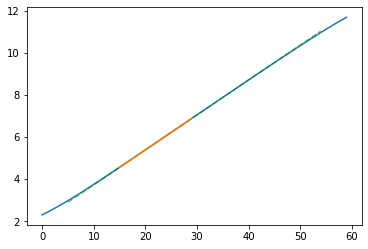

In [52]:
data_to_fit = pd.Series(res['i']).iloc[:60].apply(math.log)
plt.plot(np.arange(len(data_to_fit)), data_to_fit.values)

move = 15

data_to_fit = pd.Series(res['i']).iloc[move:30].apply(math.log)
par = np.polyfit(np.arange(len(data_to_fit)),data_to_fit.values,1)

x = np.arange(-10,40)
plt.plot(x+move, par[0]*x+par[1], linestyle='--', color='green', alpha=0.5)
plt.plot(np.arange(len(data_to_fit))+move, data_to_fit.values)

growth_rate = par[0]

print(growth_rate)

In [53]:
## R0 = 1 + (growth rate / gamma) [see here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6962332/]

growth_rate/gamma + 1, R0

(1.4983283055733467, 1.5)